In [1]:
import string

import fv3fit
import numpy as np
import pandas as pd
import proplot
import vcm
import vcm.catalog
import xarray as xr

import cloud
import generate_training_dataset
import plotting

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
plotting.configure_style()

In [3]:
RUNDIR = "gs://vcm-ml-experiments/spencerc/2022-01-19/n2f-25km-unperturbed-snoalb/fv3gfs_run"
MODEL = "gs://vcm-ml-experiments/spencerc/2022-06-20-nudge-to-25-km-ml-models/tq-nn-snoalb-tapered-clipped-25-seed-1"

In [4]:
STATE_VARIABLES = [
    "air_temperature",
    "specific_humidity",
    "surface_geopotential",
    "pressure_thickness_of_atmospheric_layer",
    "latitude",
    "longitude"
]


NUDGING_TENDENCIES = {
    "air_temperature_tendency_due_to_nudging": "dQ1",
    "specific_humidity_tendency_due_to_nudging": "dQ2"
}

In [5]:
state = cloud.open_tape(RUNDIR, "state_after_timestep")
state = state.sel(time="2018-08-07T20:30:00").squeeze("time")
state = state[STATE_VARIABLES].load()

cos_zenith_angle = vcm.cos_zenith_angle(state.time, state.longitude, state.latitude)
state = state.assign(cos_zenith_angle=cos_zenith_angle)

In [6]:
nudging_tendencies = cloud.open_tape(RUNDIR, "nudging_tendencies")
nudging_tendencies = nudging_tendencies.sel(time="2018-08-07T20:30:00").squeeze("time")
nudging_tendencies = nudging_tendencies[NUDGING_TENDENCIES.keys()]
nudging_tendencies = nudging_tendencies.rename(NUDGING_TENDENCIES).load()

In [7]:
model = fv3fit.load(MODEL)

In [8]:
scale_factor = generate_training_dataset.nudging_tendency_scale_factor(nudging_tendencies.z)
targets = scale_factor * nudging_tendencies

In [9]:
predictions = model.predict(state)

In [10]:
snapshots = xr.concat(
    [targets, predictions],
    dim=pd.Index(["target", "prediction"], name="derivation")
)
delp, _ = xr.broadcast(state.pressure_thickness_of_atmospheric_layer, snapshots.dQ1)
snapshots = vcm.interpolate_to_pressure_levels(snapshots, delp, dim="z")

In [11]:
grid = vcm.catalog.catalog["grid/c48"].to_dask()
transects = vcm.interpolate_unstructured(
    snapshots.merge(grid),
    vcm.select.meridional_ring(lon=0)
)

In [12]:
transects = transects.swap_dims({"sample": "lat"})
transects = transects.assign_coords(pressure=transects.pressure / 100)

In [13]:
SECONDS_PER_DAY = 86400
G_PER_KG = 1000

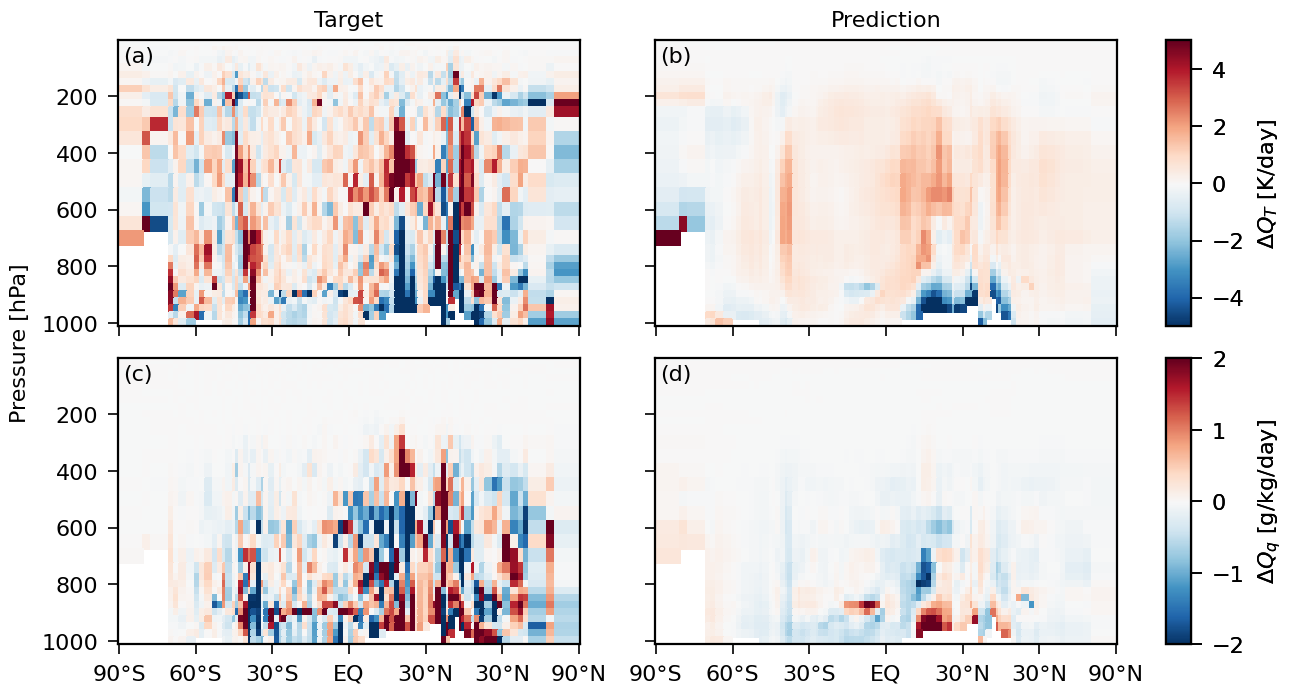

In [14]:
fig, (ax1, ax2, ax3, ax4) = proplot.subplots(ncols=2, nrows=2, figwidth=6.5, refaspect=1/0.618)

p1 = (
    (SECONDS_PER_DAY * transects.dQ1)
    .sel(derivation="target")
    .plot(ax=ax1, x="lat", vmin=-5, vmax=5, cmap="RdBu_r", add_colorbar=False, yincrease=False, discrete=False)
)
(
    (SECONDS_PER_DAY * transects.dQ1)
    .sel(derivation="prediction")
    .plot(ax=ax2, x="lat", vmin=-5, vmax=5, cmap="RdBu_r", add_colorbar=False, yincrease=False, discrete=False)
)

p2 = (
    (SECONDS_PER_DAY * G_PER_KG * transects.dQ2)
    .sel(derivation="target")
    .plot(ax=ax3, x="lat", vmin=-2, vmax=2, cmap="RdBu_r", add_colorbar=False, yincrease=False, discrete=False)
)
(
    (SECONDS_PER_DAY * G_PER_KG * transects.dQ2)
    .sel(derivation="prediction")
    .plot(ax=ax4, x="lat", vmin=-2, vmax=2, cmap="RdBu_r", add_colorbar=False, yincrease=False, discrete=False)
)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_title("")
    
ax1.set_ylabel("Pressure [hPa]")
ax3.set_ylabel("Pressure [hPa]")

ax2.set_ylabel("")
ax4.set_ylabel("")

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks(np.array([-90, -60, -30, 0, 30, 60, 90]))
    ax.set_xticklabels(np.array([u"90°S", u"60°S", u"30°S", "EQ", u"30°N", u"30°N", u"90°N"]))
    ax.set_xlabel("")

fig.colorbar(p1, loc="right", rows=(1, ), width=0.125, label="$\Delta Q_T$ [K/day]")
fig.colorbar(p2, loc="right", rows=(2, ), width=0.125, label="$\Delta Q_q$ [g/kg/day]", ticks=np.arange(-2, 2.1, 1))

ax1.set_title("Target")
ax2.set_title("Prediction")

for ax, label in zip((ax1, ax2, ax3, ax4), string.ascii_lowercase):
    ax.annotate(
        f"({label})",
        xy=(0, 1),
        xytext=(2, -2),
        va="top",
        xycoords="axes fraction",
        textcoords="offset points"
    )
    
fig.savefig("figures/figure-05.png", dpi=200)
fig.savefig("figures/figure-05.pdf")